In [2]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
old_df= pd.read_csv('diabetes_prediction_dataset.csv')
old_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
old_df.keys()

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [5]:
print(old_df['diabetes'].value_counts())
old_df.dtypes

diabetes
0    91500
1     8500
Name: count, dtype: int64


gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

# Visualization & Data Preprocessing

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder1 = LabelEncoder()
label_encoder2 = LabelEncoder()
df = old_df.copy()
df['smoking_history'] = label_encoder1.fit_transform(old_df['smoking_history'])
df['gender'] = label_encoder2.fit_transform(old_df['gender'])
df
df.dtypes




gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

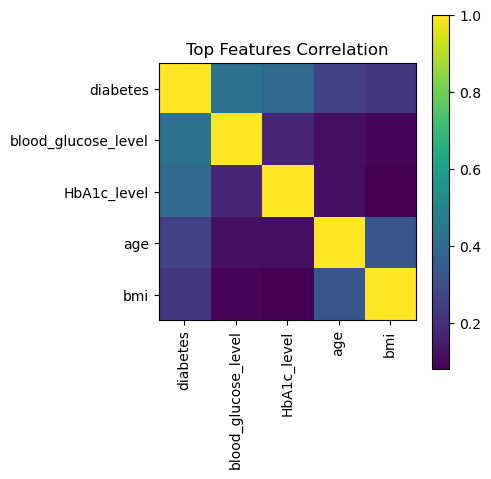

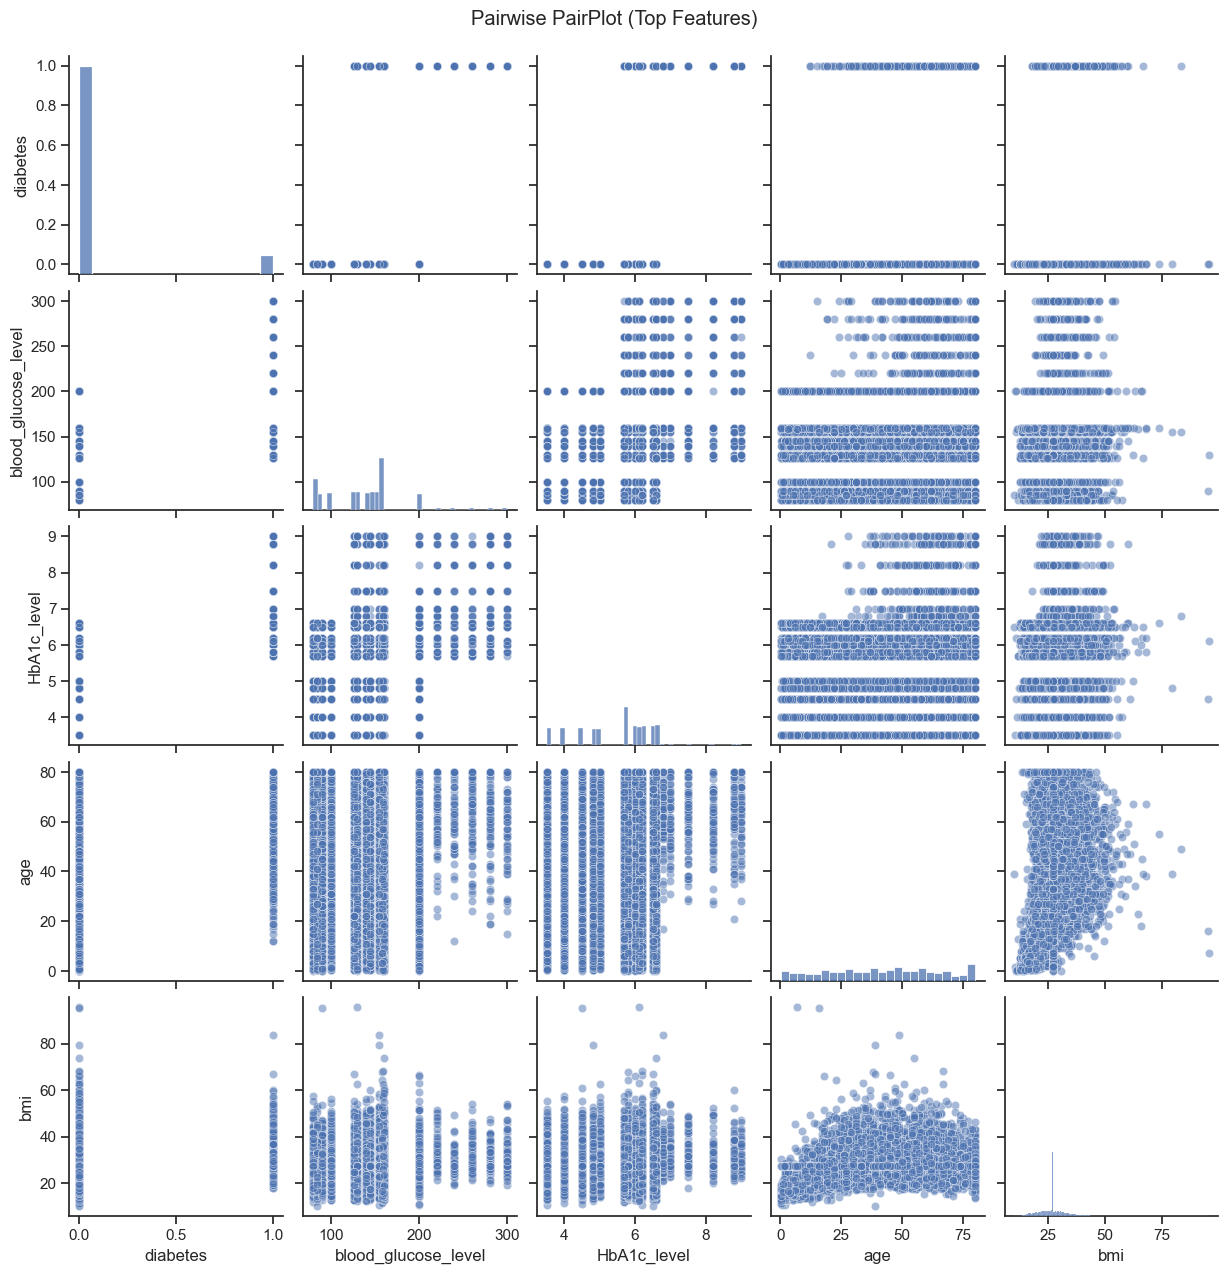

In [7]:
# Sample 1000 rows from the dataset
df_s = df.sample(n=10000, random_state=42)

#Compute correlations and pick top 5 predictors of 'diabetes'
corr = df_s.corr()
top_feats = corr['diabetes'].abs().sort_values(ascending=False).head(5).index.tolist()

# Heatmap 
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(corr.loc[top_feats, top_feats], interpolation='nearest')
ax.set_xticks(range(len(top_feats)))
ax.set_yticks(range(len(top_feats)))
ax.set_xticklabels(top_feats, rotation=90)
ax.set_yticklabels(top_feats)
fig.colorbar(im, ax=ax)
plt.title("Top Features Correlation")
plt.tight_layout()
plt.show()

# Pairplot using seaborn
sns.set_theme(style="ticks")
pair_plot = sns.pairplot(df_s[top_feats], diag_kind='hist', plot_kws={'alpha': 0.5})
pair_plot.figure.suptitle("Pairwise PairPlot (Top Features)", y=1.02)
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
X = df_s.drop(columns=['diabetes'])
y = df_s['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((8000, 8), (2000, 8), (8000,), (2000,))

# Implementation

Euclidan Distance Calculation

In [9]:
def euclidean_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    return np.linalg.norm(x1 - x2)


# K-Nearest Neighbor

K-Nearest Neighbor Class Declaration

In [10]:
class KNN:
    def __init__(self, k, distance_fn=euclidean_distance):
        self.k = k
        self.distance_fn = distance_fn
    
    def fit(self, X: np.ndarray, y: np.ndarray):
    # If pandas objects are passed, extract their values
        self.X_train = X.values if hasattr(X, "values") else X
        self.y_train = y.values if hasattr(y, "values") else y
    
    def predict(self, X: np.ndarray) -> np.ndarray:

    # Handle pandas DataFrame/Series inputs
        X_array = X.values if hasattr(X, "values") else X

        y_pred = []
        for x in X_array:
            # compute distance to all training points
            distances = np.array([
                self.distance_fn(x, x_train)
                for x_train in self.X_train
            ])
            # find the k nearest neighbors
            nn_idxs = np.argsort(distances)[: self.k]
            # pull their labels
            nn_labels = self.y_train[nn_idxs]
            # majority vote
            labels, counts = np.unique(nn_labels, return_counts=True)
            y_pred.append(labels[np.argmax(counts)])

        return np.array(y_pred)

Iterating from 1-20(arbitrary ending value) to find best k value

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
max = 0
best_y_pred = None
best_k = None
best_y_test = None
for i in range(1, 20):
    knn = KNN(k=i, distance_fn=euclidean_distance)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > max:
        max = acc
        best_k = i
        best_y_pred = y_pred
        best_y_test = y_test
print(f"Accuracy for k={best_k}: {acc}")
print(f"Accuracy: {accuracy_score(best_y_test, best_y_pred)}")
print(classification_report(best_y_test, best_y_pred))
print(confusion_matrix(best_y_test, best_y_pred))


Accuracy for k=11: 0.943
Accuracy: 0.944
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1823
           1       0.97      0.38      0.54       177

    accuracy                           0.94      2000
   macro avg       0.96      0.69      0.76      2000
weighted avg       0.95      0.94      0.93      2000

[[1821    2]
 [ 110   67]]


Accuracy for k=11: 0.943
Accuracy: 0.944
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1823
           1       0.97      0.38      0.54       177

    accuracy                           0.94      2000
   macro avg       0.96      0.69      0.76      2000
weighted avg       0.95      0.94      0.93      2000

[[1821    2]
 [ 110   67]]

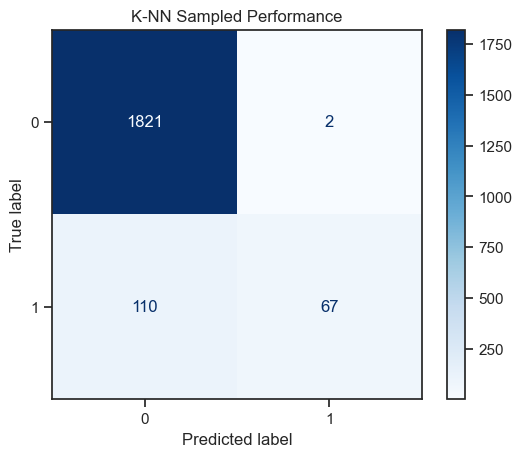

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
knn_accuracy = acc
cm = confusion_matrix(best_y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(best_y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title("K-NN Sampled Performance")
plt.show()

Using full data set with k = 11 (SKIP THIS CELL IF YOU DON'T HAVE 10 HOURS TO SPARE!)

In [40]:
X = df.drop(columns=['diabetes'])
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
knn = KNN(k=best_k, distance_fn=euclidean_distance)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"Predictions: {y_pred}")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.95185
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18292
           1       0.93      0.47      0.63      1708

    accuracy                           0.95     20000
   macro avg       0.94      0.73      0.80     20000
weighted avg       0.95      0.95      0.94     20000

[[18232    60]
 [  903   805]]


Predictions: [0 0 0 ... 0 0 0]
Accuracy: 0.95185
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18292
           1       0.93      0.47      0.63      1708

    accuracy                           0.95     20000
   macro avg       0.94      0.73      0.80     20000
weighted avg       0.95      0.95      0.94     20000

[[18232    60]
 [  903   805]]

# Logistic Regression

Logistic Regression Class Declaration

In [29]:
class LogisticRegression:
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 0.5 * (1 + np.tanh(0.5 * z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):

            linear_model = np.dot(X, self.weights) + self.bias

            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [59]:
learning_rates = [0.01, 0.05, 0.1]
epochs_list = [500, 1000, 1500]
X = df.drop(columns=['diabetes'])
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_accuracy = 0
best_learning_rate = None
best_epochs = None
best_y_pred = None

for lr in learning_rates:
    for epochs in epochs_list:
        log_reg = LogisticRegression(learning_rate=lr, epochs=epochs)
        log_reg.fit(X_train, y_train)
        y_pred = log_reg.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > best_accuracy:
            best_accuracy = acc
            best_learning_rate = lr
            best_epochs = epochs
            best_y_pred = y_pred
            best_y_test = y_test

print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Number of Epochs: {best_epochs}")
print(f"Best Accuracy: {best_accuracy}")

print(f"Accuracy (best model): {accuracy_score(best_y_test, best_y_pred)}")
print(f"Accuracy: {accuracy_score(best_y_test, best_y_pred)}")
print(classification_report(best_y_test, best_y_pred))
print(confusion_matrix(best_y_test, best_y_pred))


Best Learning Rate: 0.01
Best Number of Epochs: 500
Best Accuracy: 0.9146
Accuracy (best model): 0.9146
Accuracy: 0.9146
              precision    recall  f1-score   support

           0       0.91      1.00      0.96     18292
           1       0.00      0.00      0.00      1708

    accuracy                           0.91     20000
   macro avg       0.46      0.50      0.48     20000
weighted avg       0.84      0.91      0.87     20000

[[18292     0]
 [ 1708     0]]


c:\Coding\anaconbruh\envs\itcs-3156\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\anaconbruh\envs\itcs-3156\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\anaconbruh\envs\itcs-3156\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


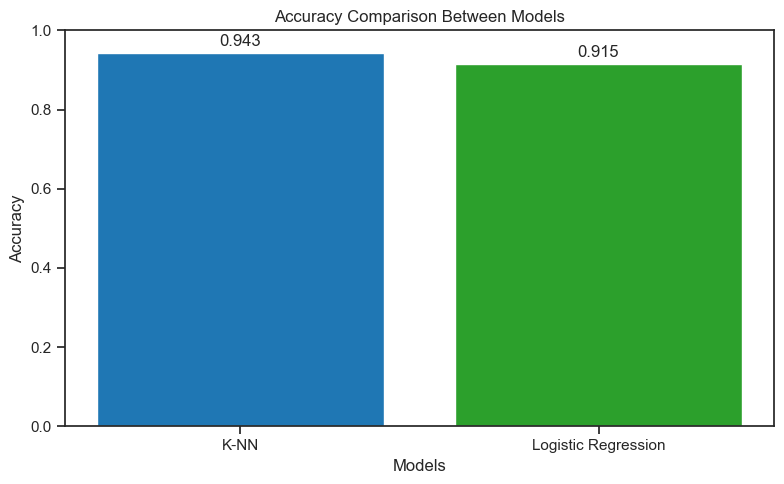

In [58]:
from sklearn.metrics import accuracy_score

# 1. Compute each model’s accuracy
#knn_accuracy = accuracy_score(knn_y_test, knn_y_pred)
lr_accuracy  = accuracy_score(best_y_test, best_y_pred)

# 2. Prepare for plotting
models     = ['K-NN', 'Logistic Regression']
accuracies = [0.943, 0.9146]

# 3. Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#2ca02c'])
plt.ylim(0, 1.0)
plt.title('Accuracy Comparison Between Models')
plt.ylabel('Accuracy')
plt.xlabel('Models')

# 4. Annotate each bar with its accuracy value
for bar, acc in zip(bars, accuracies):
    x = bar.get_x() + bar.get_width() / 2
    y = acc + 0.01
    plt.text(x, y, f"{acc:.3f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


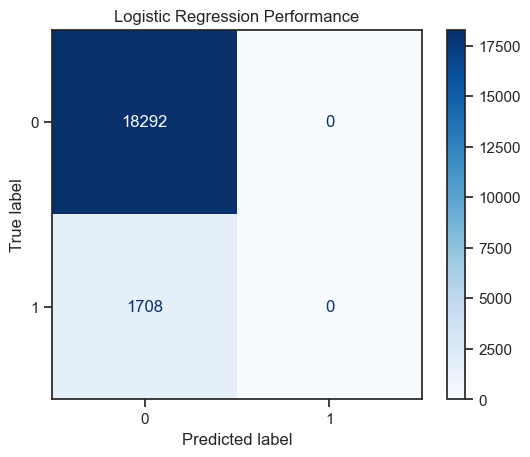

In [62]:
cm = confusion_matrix(best_y_test, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Performance")
plt.show()

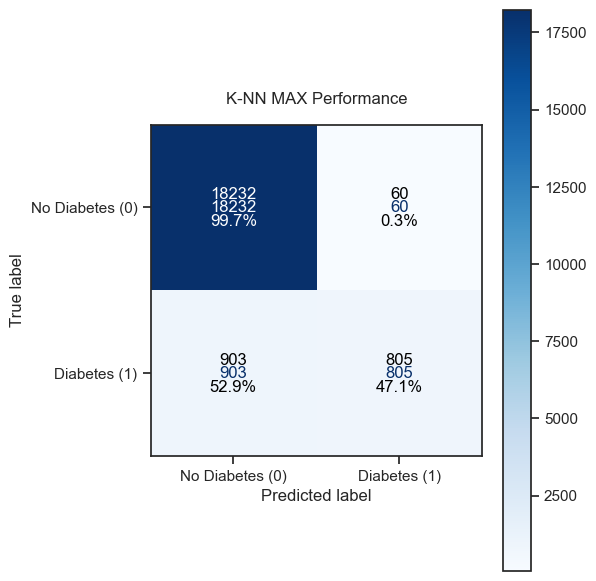

In [56]:
# Confusion matrix with raw values from full dataset k-nn
cm = np.array([[18232,   60],
               [  903,  805]])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes (0)', 'Diabetes (1)'])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax,
          cmap=plt.cm.Blues,
          values_format='')
ax.set_title("K-NN MAX Performance", pad=15)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")  # no default text


# Annotated with counts and percentages
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        pct = count / cm.sum(axis=1)[i] * 100
        ax.text(j, i, f"{count}\n{pct:.1f}%", 
                ha="center", va="center",
                color="white" if count > thresh else "black",
                linespacing=2,
                fontsize=12)

plt.tight_layout()
plt.show()

In [55]:
import pandas as pd
from IPython.display import display

# Assuming df is already loaded
schema_df = pd.DataFrame({
    'dtype':      df.dtypes.astype(str),
    'num_unique': df.nunique(),
    'min':        df.min(numeric_only=False),
    'max':        df.max(numeric_only=False),
    'mean':       df.mean(numeric_only=True),
})

# (Optional) sort columns alphabetically
schema_df = schema_df.sort_index()

# Display in Jupyter
display(schema_df)

,dtype,num_unique,min,max,mean
HbA1c_level,float64,18,3.50,9.00,5.527507
age,float64,102,0.08,80.00,41.885856
blood_glucose_level,int64,18,80.00,300.00,138.058060
bmi,float64,4247,10.01,95.69,27.320767
diabetes,int64,2,0.00,1.00,0.085000
gender,int64,3,0.00,2.00,0.414660
heart_disease,int64,2,0.00,1.00,0.039420
hypertension,int64,2,0.00,1.00,0.074850
smoking_history,int64,6,0.00,5.00,2.179650


In [53]:
# Print the range of possible values for the 'smoking_history' column
print(f"Range of possible values for 'smoking_history': {old_df['smoking_history'].unique()}")
print(f"Range of possible values for 'smoking_history': {df['smoking_history'].unique()}")
print(f"Range of possible values for 'smoking_history': {old_df['gender'].unique()}")
print(f"Range of possible values for 'smoking_history': {df['gender'].unique()}")

Range of possible values for 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Range of possible values for 'smoking_history': [4 0 1 3 2 5]
Range of possible values for 'smoking_history': ['Female' 'Male' 'Other']
Range of possible values for 'smoking_history': [0 1 2]


In [56]:
mapping = dict(zip(label_encoder1.classes_, label_encoder1.transform(label_encoder1.classes_)))
print("smoking_history → encoded value:")
for category, code in mapping.items():
    print(f"  {category!r} → {code}")

mapping = dict(zip(label_encoder2.classes_, label_encoder2.transform(label_encoder2.classes_)))
print("smoking_history → encoded value:")
for category, code in mapping.items():
    print(f"  {category!r} → {code}")

smoking_history → encoded value:
  'No Info' → 0
  'current' → 1
  'ever' → 2
  'former' → 3
  'never' → 4
  'not current' → 5
smoking_history → encoded value:
  'Female' → 0
  'Male' → 1
  'Other' → 2
